In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.plotting import register_matplotlib_converters
from matplotlib.pylab import rcParams
register_matplotlib_converters()

#Suppress default INFO logging
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('data/tx_hospital_discharges.csv', index_col='Date', parse_dates=True)

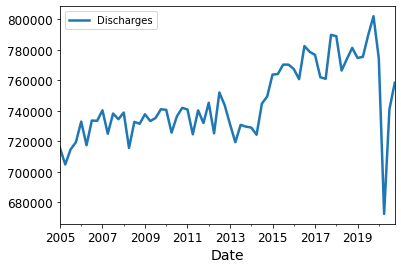

In [3]:
df.plot(linewidth=2.5)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Date',size=14);

In [4]:
df_1yr = df.rolling(window=4).mean()
df_2yr = df.rolling(window=8).mean()

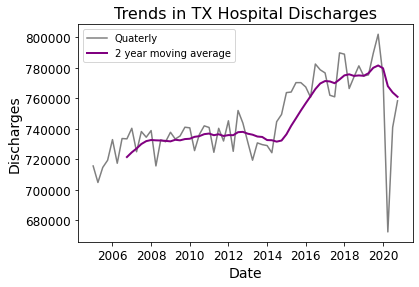

In [5]:
fig, ax = plt.subplots()
ax.plot(df, color='grey', label='Quaterly')
# ax.plot(df_1yr, linewidth=2.0, label='1 yr MA')
ax.plot(df_2yr, color='Purple', linewidth=2.0, label='2 year moving average')
ax.legend()
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Discharges', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title('Trends in TX Hospital Discharges', fontsize=16);

Stationarity, Trends:
- Assess with Dickey-Fuller

Removing trends w/ log transformation, subtracting rolling mean, EMAs, differencing, decomposition. <br>
White noise model, random walk model <br>
Correlation & autocorrelation

ARMA
1. detrend w/ differencing
2. ACF, PACF of the time series
3. decide on AR, MA, & order
4. fit to get correct params, use for prediction

In [6]:
decomposition = seasonal_decompose(df, model='additive')
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

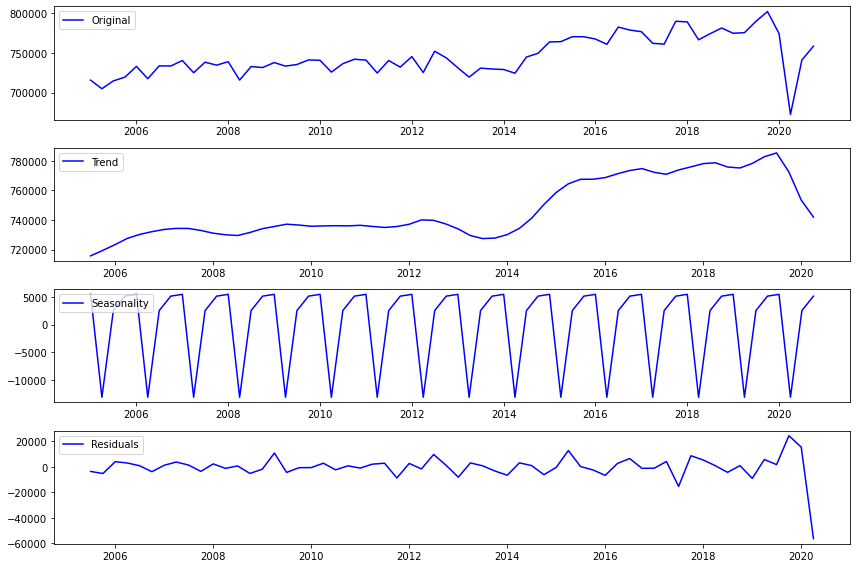

In [7]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

In [8]:
dftest = adfuller(df)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print(dfoutput)

(-1.0672483343315673, 0.7279546585718507, 10, 53, {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}, 1163.1485116961744)
Test Statistic                 -1.067248
p-value                         0.727955
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


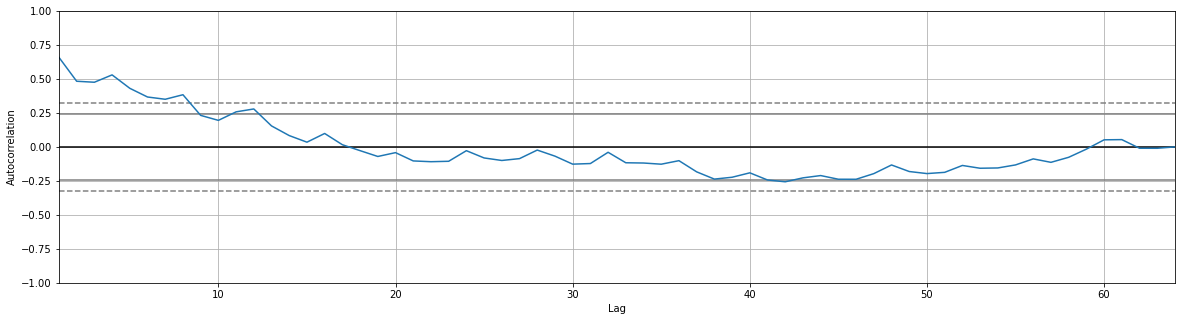

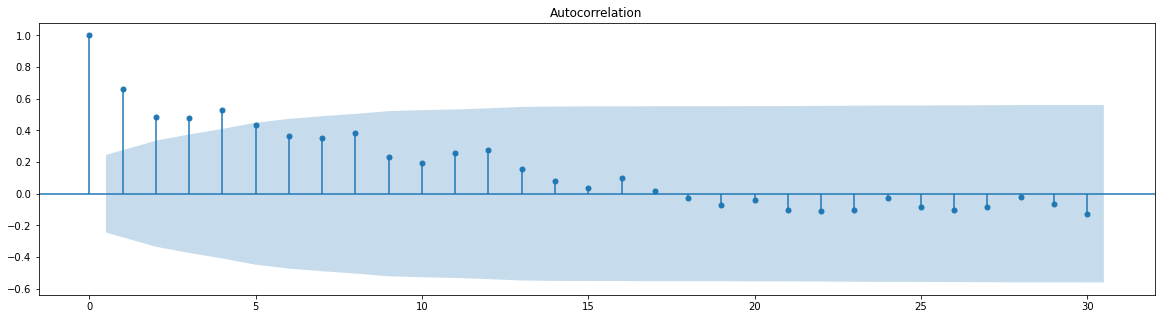

In [9]:
#ACF using plotting
plt.figure(figsize=(20, 5))
pd.plotting.autocorrelation_plot(df);

# ACF for MA term
rcParams['figure.figsize'] = 20, 5
plot_acf(df, lags=30, alpha=0.05);

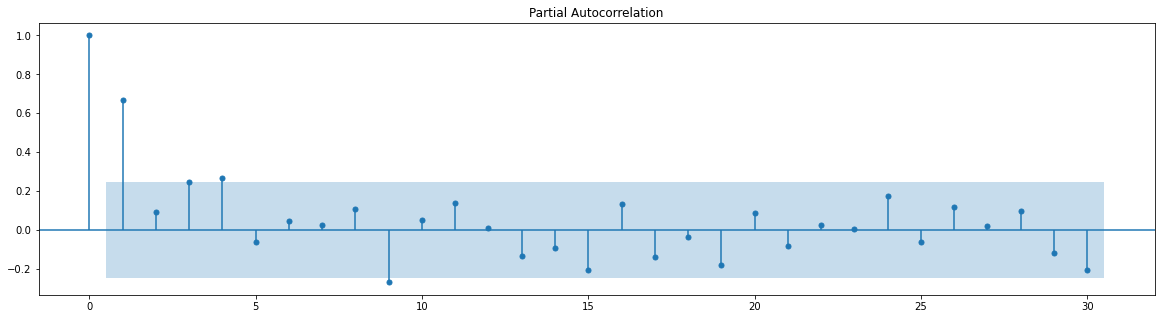

In [10]:
# PACF for AR term
rcParams['figure.figsize'] = 20, 5
plot_pacf(df, lags=30, alpha=0.05);

In [11]:
logged_df = df.apply(lambda x : np.log(x))

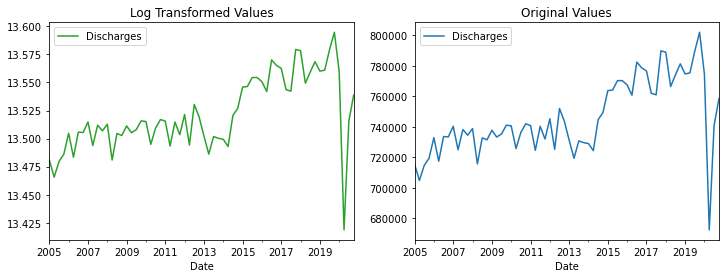

In [12]:
ax1 = plt.subplot(121)
logged_df.plot(figsize=(12,4) ,color="tab:green", title="Log Transformed Values", ax=ax1);
ax2 = plt.subplot(122)
df.plot(color="tab:blue", title="Original Values", ax=ax2);

In [13]:
dftest = adfuller(logged_df)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print(dfoutput)

(-1.0727044382064845, 0.7258334315480324, 10, 53, {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}, -240.1144401289813)
Test Statistic                 -1.072704
p-value                         0.725833
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


In [14]:
logged_df_roll_mean = logged_df.rolling(window=2).mean()
logged_df_minus_roll_mean1 = logged_df - logged_df_roll_mean
logged_df_minus_roll_mean1.dropna(inplace=True)

In [15]:
dftest = adfuller(logged_df_minus_roll_mean1)
# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print(dfoutput)

# p-value now below <.05

(-2.878099032519394, 0.047954699781338005, 9, 53, {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}, -305.06453747663966)
Test Statistic                 -2.878099
p-value                         0.047955
#Lags Used                      9.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


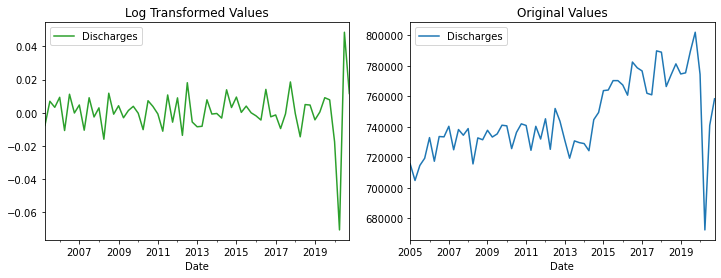

In [16]:
ax1 = plt.subplot(121)
logged_df_minus_roll_mean1.plot(figsize=(12,4) ,color="tab:green", title="Log Transformed Values", ax=ax1);
ax2 = plt.subplot(122)
df.plot(color="tab:blue", title="Original Values", ax=ax2);

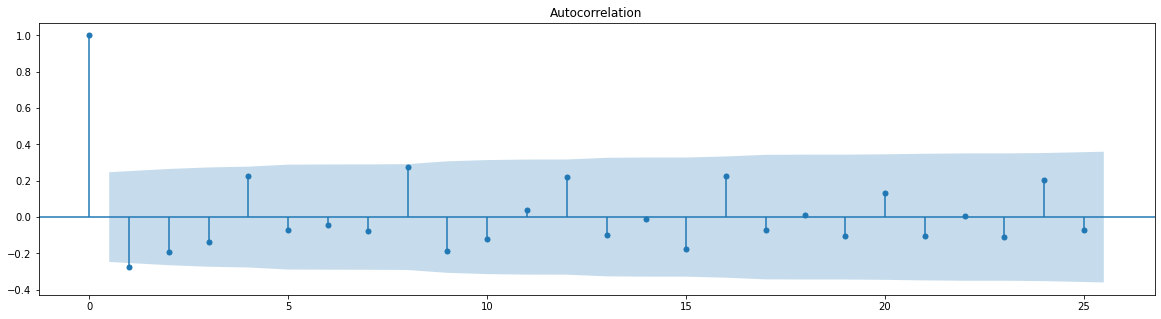

In [17]:
rcParams['figure.figsize'] = 20, 5
plot_acf(logged_df_minus_roll_mean1, lags=25, alpha=0.05);

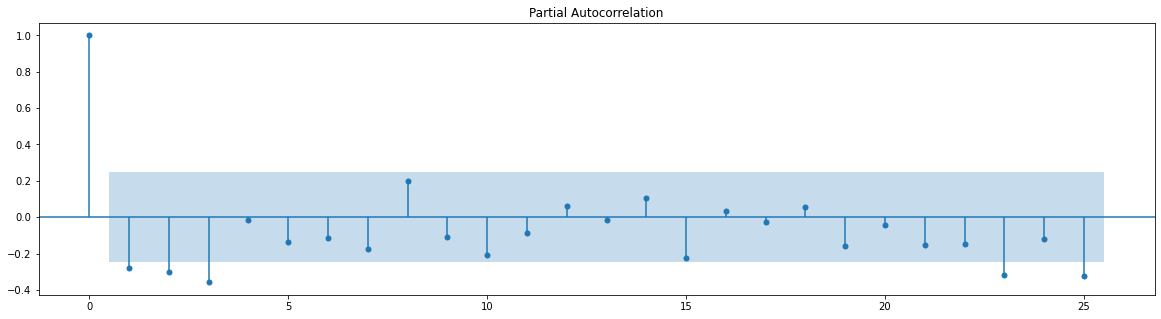

In [18]:
rcParams['figure.figsize'] = 20, 5
plot_pacf(logged_df_minus_roll_mean1, lags=25, alpha=0.05);

In [19]:
# Instantiate & fit model with statsmodels
#p = num lags - ACF
p = 4

 # q = lagged forecast errors - PACF
q = 2


# Fitting ARMA model and summary
ar = ARMA(logged_df_minus_roll_mean1,order=(p, q)).fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Discharges   No. Observations:                   63
Model:                     ARMA(4, 2)   Log Likelihood                 188.632
Method:                       css-mle   S.D. of innovations                nan
Date:                Thu, 10 Mar 2022   AIC                           -361.265
Time:                        19:38:23   BIC                           -344.120
Sample:                    04-01-2005   HQIC                          -354.522
                         - 10-01-2020                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0005      0.000      2.906      0.004       0.000       0.001
ar.L1.Discharges    -0.3987      0.037    -10.696      0.000      -0.472      -0.326
ar.L2.Discharges     0.2688        nan        nan        nan         nan         nan
ar.L3.Discharges    -0.0291        nan        nan        nan         nan         nan
ar.L4.Discharges     0.3034      0.005     59.596      0.000       0.293       0.313
ma.L1.Discharges -3.776e-08        nan        nan        nan         nan         nan
ma.L2.Discharges    -1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0000           -0.0000j            1.0000           -0.5000
AR.2            1.3842           -0.0000j            1.3842           -0.0000
AR.3           -0.1442           -1.5362j            1.5430           -0.2649
AR.4           -0.1442           +1.5362j            1.5430            0.2649
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

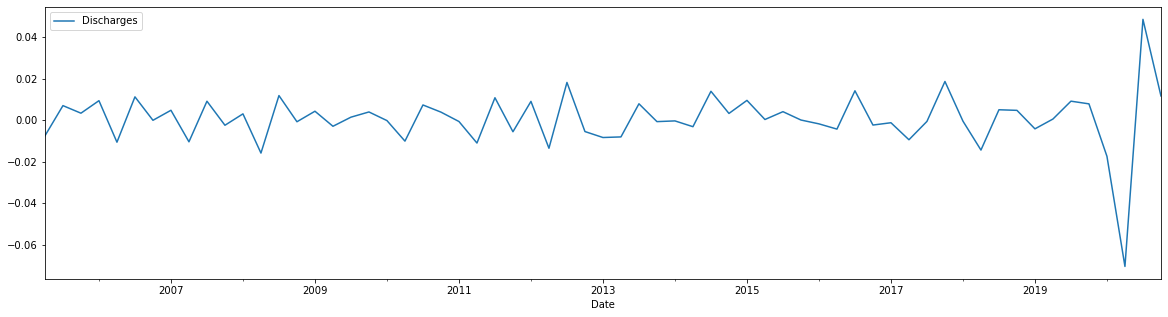

In [20]:
logged_df_minus_roll_mean1.plot();

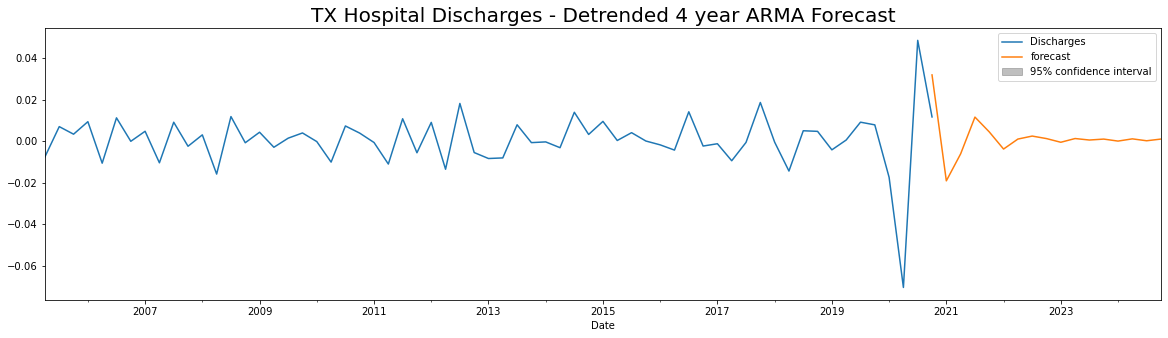

In [21]:
#plot of ARMA model
fig, ax = plt.subplots()
ax = logged_df_minus_roll_mean1.plot(ax=ax, figsize=(20,5))
ax.set_title('TX Hospital Discharges - Detrended 4 year ARMA Forecast', fontsize=20)
fig = ar.plot_predict('2020-10-01', '2024-10-01', dynamic=True, ax=ax, plot_insample=False)
plt.show()

In [22]:
# pip install statsmodels==0.11.0

In [23]:
import statsmodels
statsmodels.__version__


'0.11.0'

###### LSTM but needs work

Ref: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [24]:
# Imports
import numpy as np
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
#Supress default INFO logging
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
#SOMETHING IS WRONG IN THE CELL BELOW / DONT USE THIS LSTM

In [26]:
raw_input_test = list(df['Discharges'])
# raw_input_test
np.shape(df.index)

(64,)

In [27]:
raw_input_test_nocovid = raw_input_test[0:60]

In [28]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = raw_input_test_nocovid

# choose a number of time steps
n_steps_in, n_steps_out = 10, 10

# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))


# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=100, verbose=0)

In [29]:
x_input = array(raw_seq[50:60])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[648704.   865687.9  563790.25 814436.2  687032.6  841727.56 528975.5
  884972.1  602735.   833243.6 ]]


In [30]:
np.shape(list(yhat))

(1, 10)

In [31]:
y_hat1 = np.reshape(yhat, (10,1))
np.shape(y_hat1)

(10, 1)

In [32]:
x_list = list(range(0,60))

Text(0.5, 1.0, 'TX Hospital Discharges - LSTM PREDICTION')

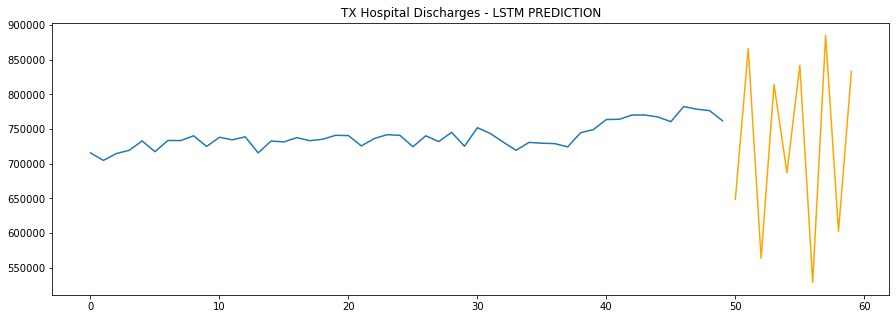

In [33]:
plt.figure(figsize=(15,5))
fig =plt.plot(x_list[0:50], df['Discharges'][0:50])
ax = plt.plot(x_list[50:60], y_hat1, color='orange')
plt.title('TX Hospital Discharges - LSTM PREDICTION')

###### FB prophet



In [34]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
#Supress default INFO logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
logging.disable(sys.maxsize)
from fbprophet.diagnostics import cross_validation

Text(0, 0.5, 'Values')

<Figure size 432x288 with 0 Axes>

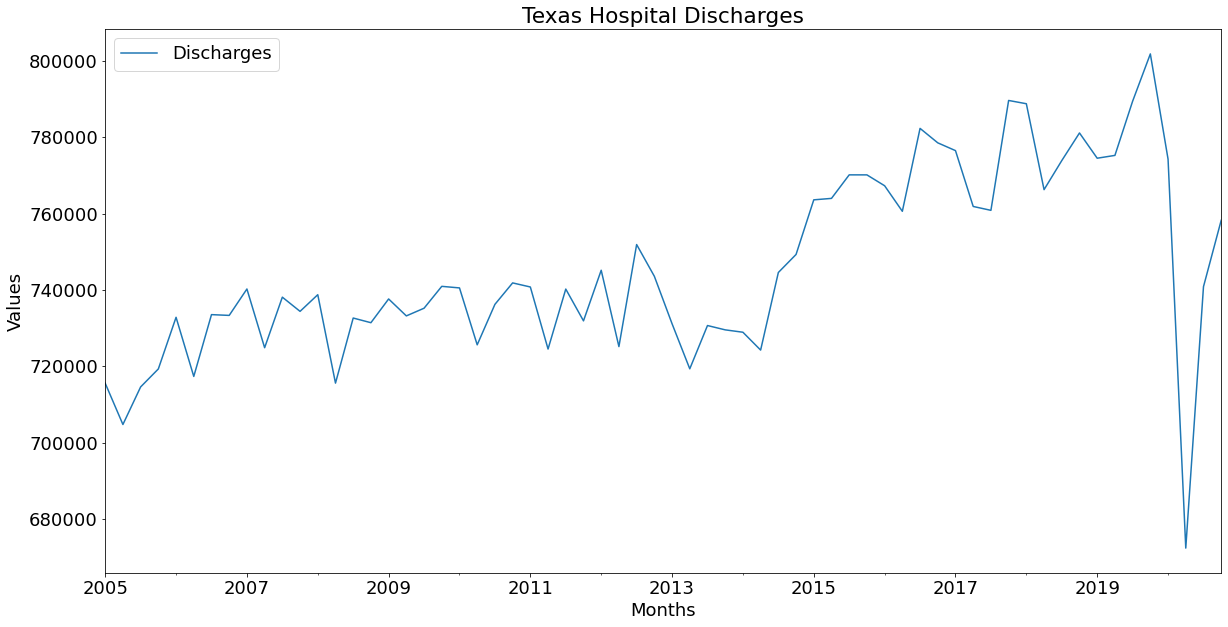

In [35]:
plt.figure()
plt.rcParams.update({'font.size': 18})
ax = df.plot(title='Texas Hospital Discharges', figsize=(20,10))
ax.set_xlabel('Months')
ax.set_ylabel('Values')

In [36]:
prof_df = df.reset_index()
prof_df['y'] = prof_df['Discharges']
prof_df['ds'] = prof_df['Date']

In [37]:
prof_df.drop(['Date', 'Discharges'],axis=1, inplace=True)

<Figure size 432x288 with 0 Axes>

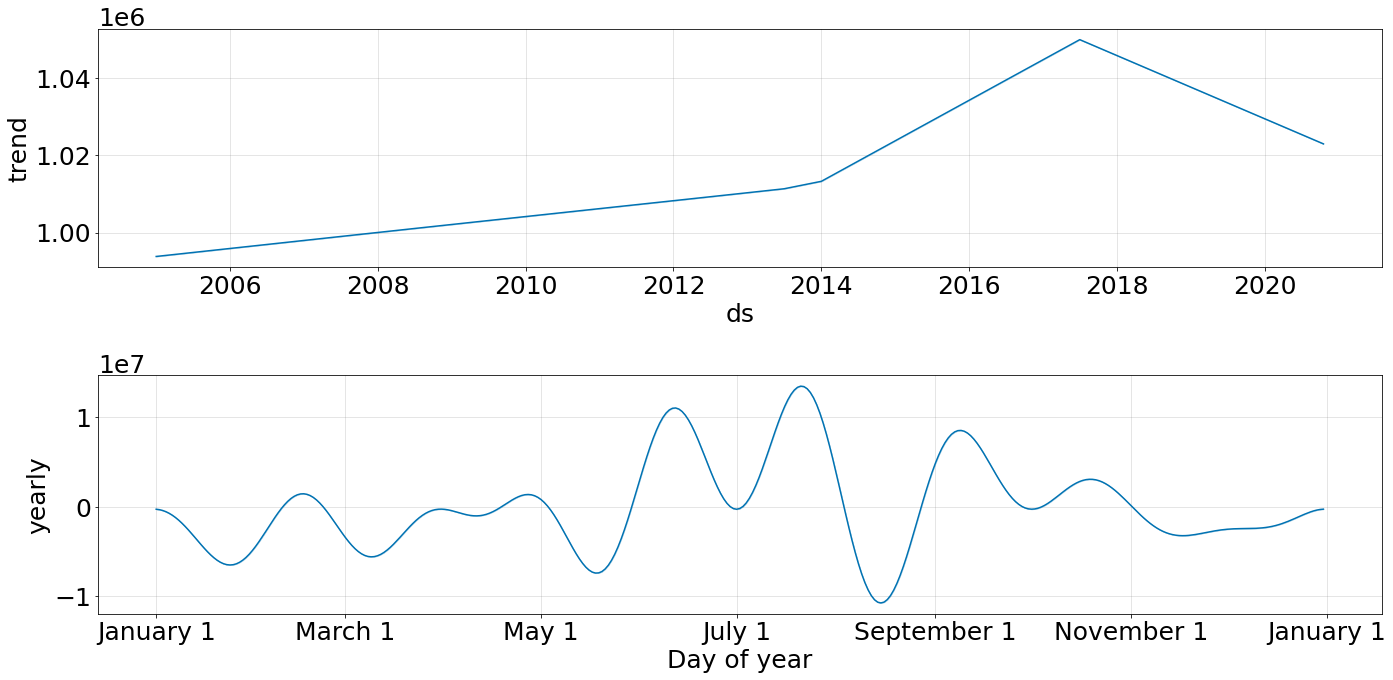

In [38]:
m = Prophet(seasonality_mode='additive').fit(prof_df)
future = m.make_future_dataframe(periods=16)
fcst = m.predict(future)
plt.figure()
plt.rcParams.update({'font.size': 25})
fig = m.plot_components(fcst, figsize=(20,10))

In [39]:
prof_df['cap'] = 19
m = Prophet(growth='logistic', changepoint_range=0.2)
m.fit(prof_df)

Text(0.5, 1.0, 'TX Hospital Discharges - FACEBOOK PROPHET 4 YEAR PREDICTION')

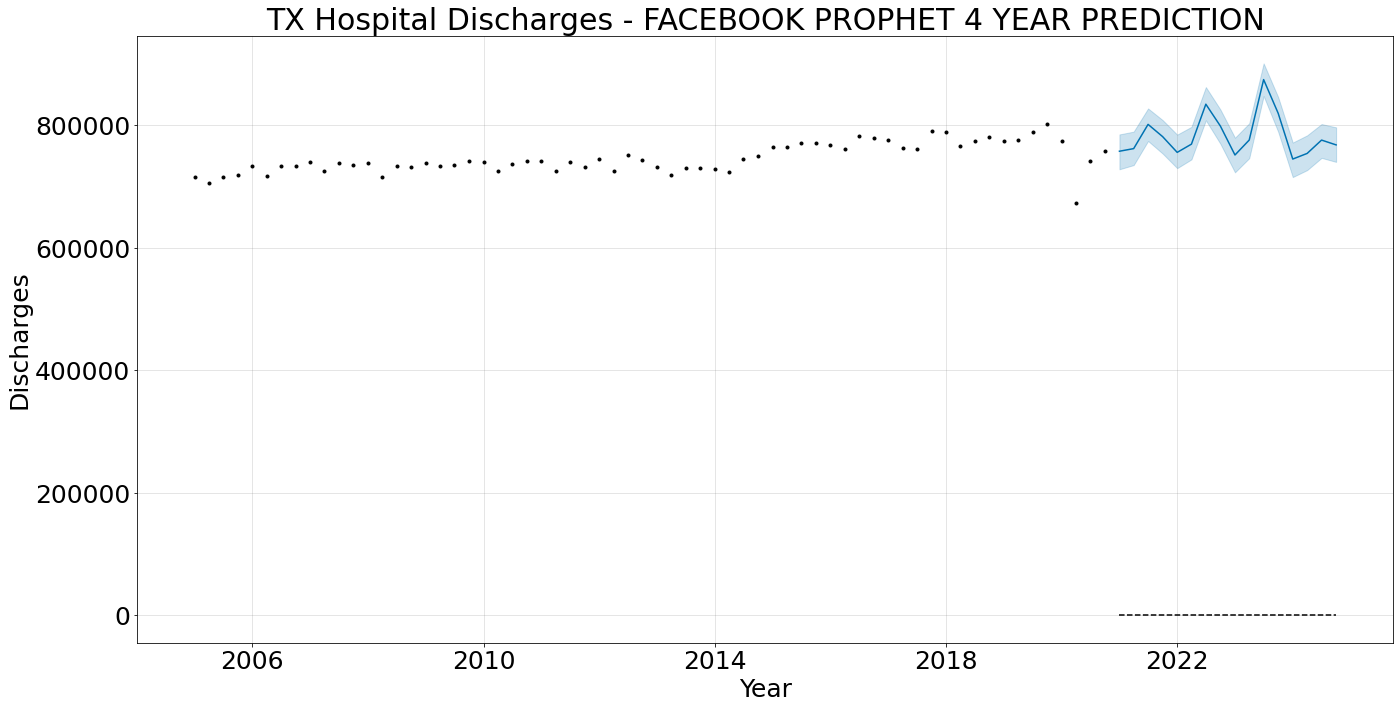

In [40]:
future = m.make_future_dataframe(freq='Q', periods=16, include_history=False)
future['cap'] = 18
fcst = m.predict(future)
fig = m.plot(fcst, xlabel='Year', ylabel='Discharges', figsize=(20,10))
plt.title('TX Hospital Discharges - FACEBOOK PROPHET 4 YEAR PREDICTION')